# Portfolio Optimization
### For https://www.hslu.ch/de-ch/hochschule-luzern/forschung/projekte/detail/?pid=5520

In [1]:
import numpy as np
import pandas as pd

from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram

from utils.phase_estimator import get_phase_estimation
from utils.grover import GroverSolver
from utils.counting import get_count
from utils.misc import execute_circ,simulator

## V1 (based on https://github.com/ix-stefstet/qaif/blob/master/src/py/SharpeRatioWithQuantumCounting.py)
only two assets are considered

In [2]:
no_of_assets_to_consider = 2 # right now only 2 is supported

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

def precalculate_solutions(ws,s_threshold): return [i for i,w in enumerate(ws) if get_sharpe(w)>s_threshold]

(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 6
---------------------------------------------
s_above: 0.5 , s_threshold: 0.25, s_below: 0
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.25 , s_threshold: 0.125, s_below: 0
Winning portfolios:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] -> 10 / 16
theta:  0.375 pi
Measured #Sol  | Error Bound   
10.0           | 7.29          
---------------------------------------------
s_above: 0.25 , s_threshold: 0.1875, s_below: 0.125
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s_above: 0.1875 , s_threshold: 0.15625, s_below: 0.125
Winning portfolios:  [] -> 0 / 16
theta:  0.0 pi
Measured #Sol  | Error Bound   
0.0            | 0.13          
---------------------------------------------
s

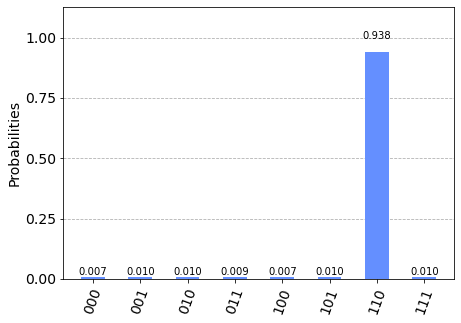

In [3]:
s_above = 0.5
s_below = 0

success_chance = 0.8
bit_accuracy = 2
n = 4 # number of grover qubits. 2**n portfolios will be considered
ws = [np.array([w1,1-w1]) for w1 in np.linspace(0,1,2**n)] # N = 2**n many portfolios

print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax([*map(get_sharpe,ws)]))

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while abs(s_above - s_below) > 0.01 or no_of_solutions == 0:
    print('-' * 45)

    s_threshold = (s_above + s_below) / 2
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")

    solutions = precalculate_solutions(ws,s_threshold)
    print('Winning portfolios: ',solutions, '->',len(solutions),'/', 2**n)


    grov_sol = GroverSolver(solutions)
    grover_op = grov_sol['grover_op']

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op)

    # It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative phased eigenvalue
    theta = abs(np.pi-theta)
    print('theta: ', theta/np.pi,'pi')

    no_of_solutions = round(no_of_solutions)

    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

print('-' * 45,'\n')

# Now that we have found the correct grover op, we can do amplification. 
# We also use the theta, which we have found during Quantum Counting, for determining the number of calls to the oracle.
n = grover_op.num_qubits
t = round(0.5 * (np.pi/theta - 1)) if theta != 0 else 0
print('Number of calls to the oracle:',t)
circ = QuantumCircuit(n)
circ.h(circ.qubits)
for _ in range(t):
    circ.append(grover_op.to_gate(),circ.qubits)

circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get),2))

plot_histogram(counts)
